In [1]:
import pickle
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import psutil  # to monitor memory
%load_ext autoreload
%autoreload 2
%aimport Master
%aimport Separation
%aimport Methods
%aimport Data

In [2]:
sep_env = gp.Env()
sep_env.setParam('Method', 0)
sep_env.setParam('OutputFlag', 0)
sep_env.setParam('NumericFocus', 2)
sep_env.setParam('DualReductions', 0)

master_env = gp.Env()
master_env.setParam('OutputFlag', 1)
master_env.setParam('TimeLimit', 600)
master_env.setParam('MIPGap', 0.005)

Set parameter Username
Set parameter LicenseID to value 2625858
Academic license - for non-commercial use only - expires 2026-02-20
Set parameter Method to value 0
Set parameter Username
Set parameter LicenseID to value 2625858
Academic license - for non-commercial use only - expires 2026-02-20
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.005


In [22]:
from Data import ModelsData
mg_id = 1 # 0: Dove Springs, 1: Sunnyside, 2: Rogers
data = ModelsData(mg_id=mg_id)
scale = 1

In [27]:
np.min(data.PV[:4])

0.0

In [4]:
# Build separation models
from Separation import Separation
separations = []
for scenario_index in tqdm(range(len(data.Pr))):
    separations.append(Separation(data=data, scenario_index=scenario_index, env=sep_env))
mem = psutil.virtual_memory()
print(f"Used: {mem.percent}% | Available: {mem.available / 1e9:.2f} GB")

100%|██████████| 27/27 [14:55<00:00, 33.16s/it]

Used: 65.6% | Available: 5.82 GB


In [6]:
from Methods import get_T_r
TMatrices, rVectors = zip(*[get_T_r(sep, data) for sep in separations])

### Building scenarios

In [7]:
# Double and half community scale
scale = 0.5
for s, sep in zip(data.Sc, separations):
    load_gr = data.LG[s[2]]
    load_growth = [(1 + i * data.n * load_gr) for i in data.i_index]
    for i, g, t in np.ndindex(data.I, data.G, data.T):
        constr = sep.model.getConstrByName(f'load[{i},{g},{t}]')
        constr.RHS = scale * load_growth[i] * sep.load_demand[i, g, t]

    for l in data.l_index:
        for d in data.d_index:
            constr = sep.model.getConstrByName(f'device_ub_install[{l},{d}]')
            sep.model.chgCoeff(constr, sep.U_I[l], 1.25 * data.device_ub[l, d] * scale)

    constr = sep.model.getConstrByName('dg_ub_install')
    constr.RHS = -scale * 1.25 * data.device_ub[0, 2]
    sep.model.update()
TMatrices, rVectors = zip(*[get_T_r(sep, data) for sep in separations])

In [27]:
# Modify drp rate
drp_rate = 0.2
for sep in separations:
    for i, g, t in np.ndindex(data.I, data.G, data.T):
        constr = sep.model.getConstrByName(f'max_trans_load[{i},{g},{t}]')
        sep.model.chgCoeff(constr, sep.Load[i, g, t], drp_rate)

    e_drp = data.e_grid_import * (1 + drp_rate)
    for i in data.i_index:
        sep.model.remove(sep.model.getConstrByName(f'C_In{i}'))
        sum_DRP = sep.Y_LT[i].sum()
        sep.model.addConstr(sep.C_IN[i] == e_drp * sum_DRP, name=f'C_In{i}')
    sep.model.update()
TMatrices, rVectors = zip(*[get_T_r(sep, data) for sep in separations])

In [26]:
# Modify year of expansion
for sep in separations:
    sep.model.addConstr(sep.X_E.sum() == 0, name='no_expand')
    sep.model.update()
TMatrices, rVectors = zip(*[get_T_r(sep, data) for sep in separations])

In [32]:
# Apply expansion
for sep in separations:
    sep.model.remove(sep.model.getConstrByName('no_expand'))
    sep.model.update()
TMatrices, rVectors = zip(*[get_T_r(sep, data) for sep in separations])

### Master problem and Bender Branch and Cut

In [8]:
from Master import Master
master = Master(data, master_env, scale)
# Solve by Callback
from Methods import solve_with_BD_BandB
optimal_x, optimal_obj = solve_with_BD_BandB(
    master=master,
    seps=separations,
    probs=data.Pr,
    TMatrices=TMatrices,
    rVectors=rVectors,
    data=data)

Set parameter LazyConstraints to value 1
Set parameter NumericFocus to value 3
Set parameter LogFile to value "Models/master_log.log"
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 17 columns and 68 nonzeros
Model fingerprint: 0xbbdfb1fd
Variable types: 1 continuous, 16 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 6e+05]
  Bounds range     [1e+00, 1e+10]
  RHS range        [1e+01, 1e+06]
Presolve time: 0.00s
Presolved: 17 rows, 17 columns, 68 nonzeros
Variable types: 1 continuous, 16 integer (4 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+10   0.000000e+00   0.000000e+00     10s

Root relaxation: objective -1.000000e+10, 0 iterations, 0.01 seconds (0.00 wo

### Resulting for Scenarios

In [19]:
# Get optimal X and U
optimal_x_e = []
probs = data.Pr
for f in separations:
    vars = f.model.getVars()[:len(optimal_x)]
    f.model.setAttr('LB', vars, optimal_x)
    f.model.setAttr('UB', vars, optimal_x)
    f.model.optimize()
    optimal_x_e.append(f.X_E.x)
optimal_x_e = np.average(optimal_x_e, axis=0, weights=probs)
optimal_x_i = optimal_x[:data.L * data.D].reshape((data.L, data.D))
optimal_u_i = optimal_x[data.L * data.D:].reshape((data.L, 1))
pd.DataFrame(np.concatenate((optimal_x_i, optimal_x_e, optimal_u_i), axis=1),columns=['ES_I', 'PV_I', 'DG_I', 'ES_E', 'PV_E', 'DG_E', 'U']).to_csv(f'Results/(MG{mg_id})X(scale0.5).csv')

In [18]:
print(optimal_x_e)

[[14.66772951 43.61265155  6.625     ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


In [10]:
# Investment, Bill Saving, Resilience
from Methods import get_bill_saving
capital_I = master.X_I.X.sum(axis=0) @ data.C
capital_E = np.average([sep.capital_cost_E.x for sep in separations], weights=data.Pr)
bill_saving = np.average([get_bill_saving(sep, scenario, data, data.e_load, data.e_grid_import) for scenario, sep in zip(data.Sc, separations)], weights=data.Pr)
# Resilience
from Methods import get_resilience
Phi, Lambda, E = zip(*[get_resilience(sep, scenario, data) for scenario, sep in zip(data.Sc, separations)])
Phi = np.average(Phi, weights=data.Pr)
Lambda = np.average(Lambda, weights=data.Pr)
E = np.average(E, weights=data.Pr)
# Peak Shift
from Methods import get_peak_shift
PS = [get_peak_shift(sep, scenario, data) for scenario, sep in zip(data.Sc, separations)]
PS = np.average(PS, weights=data.Pr)
# Incentives (per year)
IN = [sep.C_IN.x.sum() for sep in separations]
IN = np.average(IN, weights=data.Pr) / 2
# Grid Purchase (per year)
GP = [sep.Y_GridL.x.sum() * data.e_grid_import for sep in separations]
GP = np.average(GP, weights=data.Pr) / 2
# Grid Sell (per year)
GS = [sep.Y_PVGrid.x.sum() * data.e_grid_export for sep in separations]
GS = np.average(GS, weights=data.Pr) / 2

# Save results
results = {}
results['Investment'] = capital_I
results['Expansion'] = capital_E
results['Bill Saving'] = bill_saving
results['Phi'] = Phi
results['Lambda'] = Lambda
results['E'] = E
results['Peak Shift'] = PS
results['Incentives'] = IN
results['Annual Grid Purchase'] = GP
results['Annual Grid Sell'] = GS

In [11]:
pd.DataFrame(results, index=['row']).to_csv(f'Results/(MG{mg_id})optimal(scale0.5).csv')

In [11]:
# Save all subproblems solutions
from Separation import save_solutions
vars, costs, pars = {}, {}, {}

for index, sep in enumerate(separations):
    name = f'Solutions/(MG{mg_id}){index}.pkl'
    save_solutions(sep, index, mg_id, name)

### Least probable scenario with most impact

In [12]:
# Scenario with the max outage with max load growth
hilp_scenario = np.argmin(data.Pr)
hilp_f = separations[hilp_scenario]

from Separation import save_solutions
save_solutions(separations[hilp_scenario], hilp_scenario, mg_id, f'Solutions/(MG{mg_id})HILP{hilp_scenario}.pkl')

In [13]:
with open(f'Solutions/(MG{mg_id})HILP{hilp_scenario}.pkl', 'rb') as file:
    vars, costs, pars = pickle.load(file)

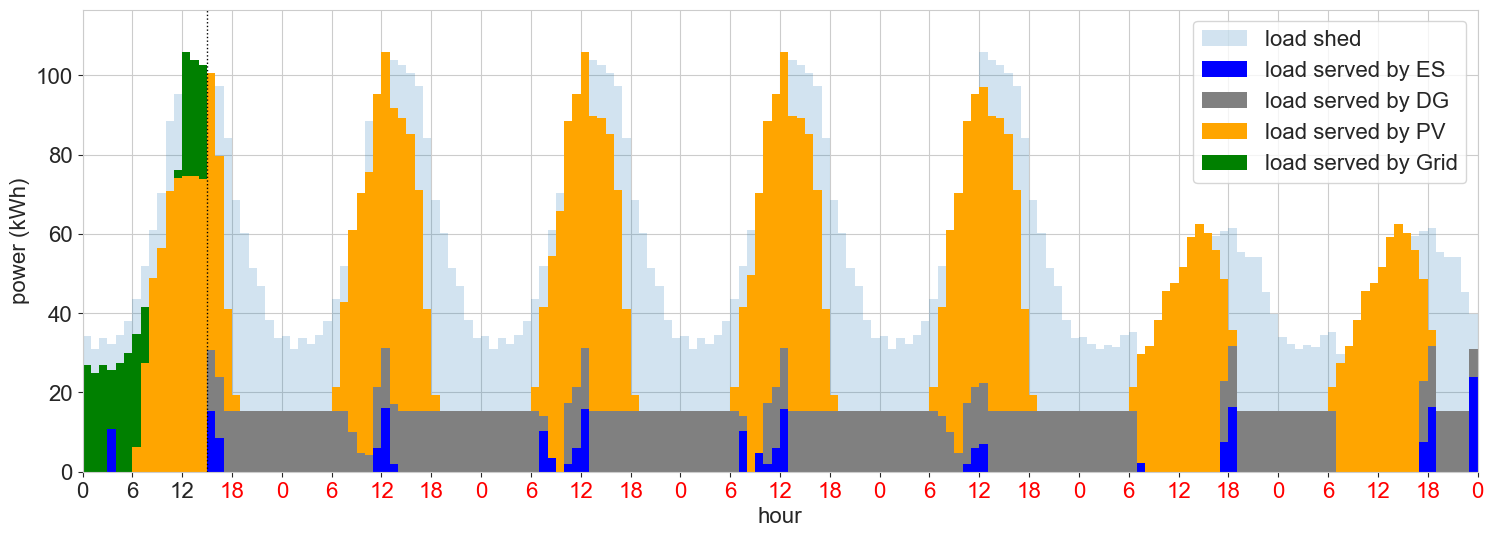

In [14]:
# Power met
plt.rcParams.update({'font.size': 16})
i, g = 0, 2
x = range(168)
y_esl = vars['y_esl'][i, g]
y_pvl = vars['y_pvl'][i, g]
y_pvl[y_pvl < 1] = 0
y_dgl = vars['y_dgl'][i, g]
y_gl = vars['y_gridl'][i, g]
y_lsh = vars['y_lsh'][i, g]
y_drp = vars['y_lt'][i, g]
y_dges = vars['y_dges'][i, g]
load = pars['load'][i, g]

# load shares
load_share = {key: 0 for key in ['ES%', 'PV%', 'DG%', 'DRP%']}
load_sum = load.sum()
load_share['ES%'] = 100 * y_esl.sum()/load_sum
load_share['PV%'] = 100 * y_pvl.sum()/load_sum
load_share['DG%'] = 100 * y_dgl.sum()/load_sum
load_share['DRP%'] = 100 * y_drp.sum()/load_sum
pd.DataFrame(load_share, index=['row']).to_csv(f'Results/(MG{mg_id})load_share.csv')

width = 1
# load plot
figure = plt.figure(figsize=(18, 6))
# Load
plt.bar(x, load, align='edge', width=width, alpha=0.2, label='load shed', edgecolor='none', zorder=1)
# ES to Load
plt.bar(x, y_esl, align='edge', width=width, color='blue', label='load served by ES', edgecolor='none')
# DG to Load
plt.bar(x, y_dgl, bottom=y_esl, align='edge', width=width,  color='gray', label='load served by DG', edgecolor='none')
# PV to Load
plt.bar(x, y_pvl, bottom=y_esl + y_dgl, align='edge', width=width,  color='orange', label='load served by PV', edgecolor='none')
# Grid to Load
plt.bar(x, y_gl, bottom=y_esl + y_pvl + y_dgl, align='edge', width=width,  color='green', label='load served by Grid', edgecolor='none')


# Y lim
plt.ylim([0, 1.1 * plt.gca().get_ylim()[1]])
# Outage time
plt.plot([15, 15], [0, plt.gca().get_ylim()[1]], ':', color='black', linewidth=1)
# Axis
plt.xticks([6*i for i in range(29)], np.concatenate((np.tile([0, 6, 12, 18], 7), np.array([0]))))
[x.set_color('red') for x in plt.gca().get_xticklabels()[3:]]
plt.xlabel('hour')
plt.ylabel('power (kWh)')
plt.xlim([0, 168])
plt.tick_params(axis='x', which='both', bottom=True, top=False)
plt.tick_params(axis='y', which='both', left=True, right=False)
plt.legend()
plt.savefig(f'IMG/(MG{mg_id})power_met.jpg', bbox_inches='tight', dpi=600)

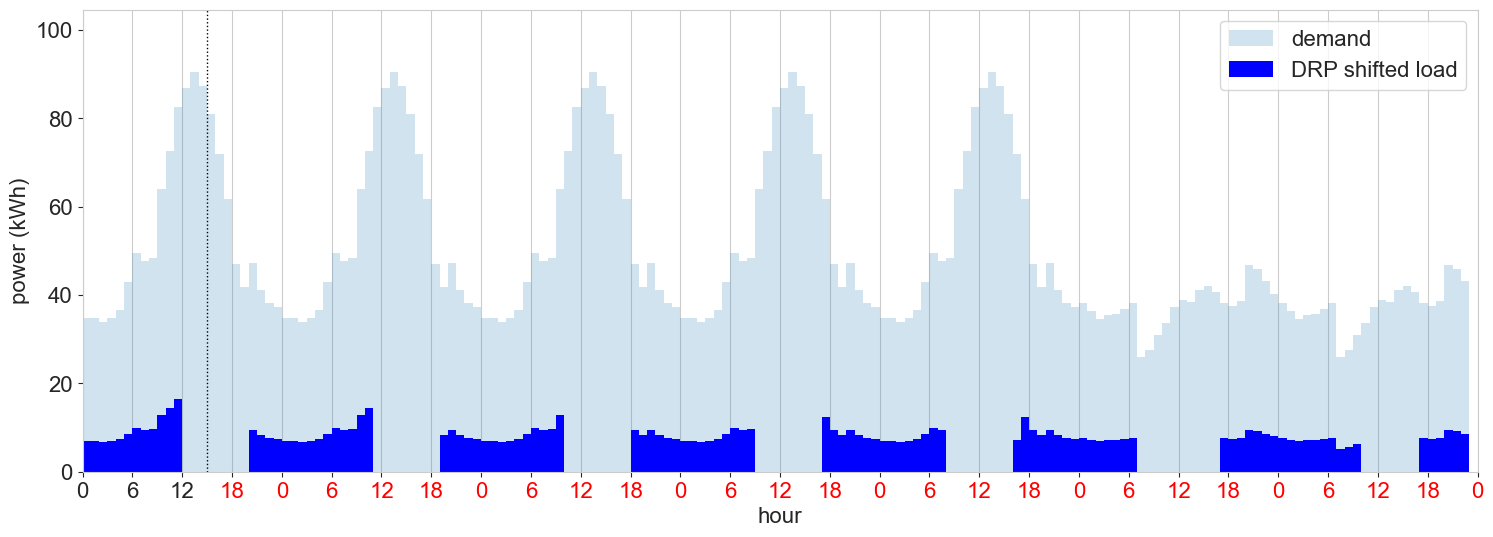

In [131]:
y_lt = vars['y_lt'][i, g]
# load plot
figure = plt.figure(figsize=(18, 6))
# Load
plt.fill_between(x, load, step='post', alpha=0.2, label='demand',edgecolor='none')
# ES to Load
plt.bar(x, y_lt, align='edge', width=width, color='blue', label='DRP shifted load',edgecolor='none')
# Y lim
plt.ylim([0, 1.1 * plt.gca().get_ylim()[1]])
# Outage time
plt.plot([15, 15], [0, plt.gca().get_ylim()[1]], ':', color='black', linewidth=1)
# Axis
plt.xticks([6*i for i in range(29)], np.concatenate((np.tile([0, 6, 12, 18], 7), np.array([0]))))
[x.set_color('red') for x in plt.gca().get_xticklabels()[3:]]
plt.xlabel('hour')
plt.ylabel('power (kWh)')
plt.xlim([0, 168])
plt.legend()
plt.grid(axis='y')
plt.tick_params(axis='x', which='both', bottom=True, top=False)
plt.tick_params(axis='y', which='both', left=True, right=False)
plt.savefig(f'IMG/(MG{mg_id})drp_shift.jpg', bbox_inches='tight', dpi=600)

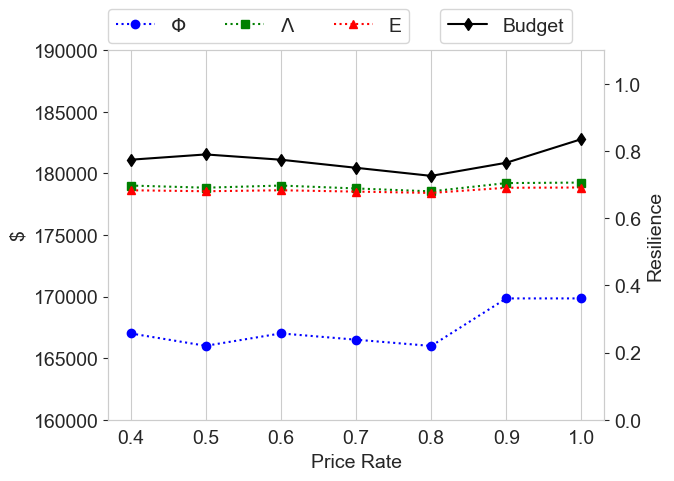

In [21]:

mg_id = 0
plt.rcParams.update({'font.size': 14})

table = pd.read_csv(f'Results/(MG{mg_id})sensitivity_price.csv')

x = table['price']
y0 = table['Investment'] + table['Expansion']
y1 = table['Expansion']
y2 = table[['Phi', 'Lambda', 'E']]
label = {'Phi': r'$\Phi$', 'Lambda': r'$\Lambda$', 'E':'E'}

figure, ax1 = plt.subplots()
# Primary axis plot
ax1.plot(x, y0, label='Budget', color='black', marker='d')
ax1.set_xlabel('Price Rate')
ax1.set_ylabel('$')
ax1.legend(ncol=1, loc=[0.67, 1.02])
ax1.grid(axis='y', which='both')
ax1.set_ylim([160000, 190000])
# Secondary axis plot
ax2 = ax1.twinx()
markers = ['o', 's', '^']
colors = ['blue', 'green', 'red']
for col, marker, color in zip(y2.columns, markers, colors):
    ax2.plot(x, y2[col], label=label[col], marker=marker, color=color, linestyle=':')
ax2.set_ylim([0, 1.1])
ax2.legend(ncol=3, loc=[0, 1.02])
ax2.set_ylabel('Resilience')
ax2.grid(False)  # Turn off grid for secondary axis

plt.savefig(f'IMG/(MG{mg_id})sensitivity_price.jpg', dpi=600)